##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 통합 그래디언트

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/interpretability/integrated_gradients"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/interpretability/integrated_gradients.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/interpretability/integrated_gradients.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/interpretability/integrated_gradients.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/google/imagenet/inception_v1/classification/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub 모델보기</a></td>
</table>

이 튜토리얼은 [딥 네트워크에 대한 공리적 속성](https://arxiv.org/abs/1703.01365) 논문에 소개된 [Explainable AI](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence) 기술인 **통합 그래디언트(IG)**를 구현하는 방법을 보여줍니다. IG는 해당 특성의 관점에서 모델 예측 사이의 관계를 설명하는 데 목적을 두고 있습니다. 특성의 중요성 이해, 데이터 기울임 식별 및 모델 성능 디버깅을 포함한 많은 사용 사례가 있습니다.

IG는 다양한 모델(예: 이미지, 텍스트, 구조화된 데이터)에 대한 적용 가능성, 구현의 용이성, 이론적 근거 및 대규모 네트워크와 이미지와 같은 요소 공간으로 확장할 수 있는 대체 접근 방식에 상대적인 계산 효율성에 힘입어 널리 통용되는 해석 기술로 자리 잡았습니다.

이 튜토리얼에서는 IG의 단계별 구현을 진행하면서 이미지 분류자의 픽셀 요소가 갖는 중요도를 이해해 보겠습니다. 예를 들어, 물을 분사하는 소방선을 나타낸 이 [이미지](https://commons.wikimedia.org/wiki/File:San_Francisco_fireboat_showing_off.jpg)를 생각해 보세요. 이 이미지는 소방선으로 분류될 것이고 이러한 결정을 내린 데는 보트와 물 대포를 구성하는 픽셀이 중요하게 작용할 것입니다. 알아볼 모델도 이 튜토리얼의 뒷부분에서 이 이미지를 소방선으로 분류하게 될 것입니다. 그러나 결정을 설명할 때 중요한 것과 동일한 픽셀을 강조합니까?

"IG Attribution Mask" 및 "Original + IG Mask Overlay" 제목의 아래 이미지에서 모델은 이 결정을 내릴 때 보트의 물 대포와 물 제트를 구성하는 픽셀을 보트 자체보다 더 중요하게 강조(보라색)한 것을 알 수 있습니다. 모델이 새로운 소방선으로 일반화하는 방식은 무엇일까요? 물 제트가 없는 소방선은 어떻게 될까요? 계속해서 IG의 작동 방식과 모델에 IG를 적용하는 방법을 자세히 알아보고 예측과 기본 특성 간의 관계를 더 잘 이해하기 바랍니다.

![Output Image 1](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/interpretability/images/IG_fireboat.png?raw=true)

## 설정

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

### TF-Hub에서 사전 훈련된 이미지 분류자 다운로드

IG는 구분 가능한 모든 모델에 적용할 수 있습니다. 원본 논문의 취지에 따라 동일한 모델의 사전 훈련된 버전인 Inception V1을 [TensorFlow Hub](https://tfhub.dev/google/imagenet/inception_v1/classification/4)에서 다운로드하여 사용합니다.

In [4]:
model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


모듈 페이지에서 Inception V1에 관한 다음 사항을 염두에 두어야 합니다.

**입력**: 모델의 예상 입력 형상은 `(None, 224, 244, 3,)`입니다. 데이터 형식이 float32이고 형상이 `(batch_size, height, width, RGB channels)`(해당 요소는 [0, 1] 범위로 정규화된 픽셀의 RGB 색상 값임)인 밀도가 높은 4D 텐서입니다. 첫 번째 요소는 모델이 임의의 정수 배치 크기를 사용할 수 있음을 나타내는 `None`입니다.

**출력** : `(batch_size, 1001)` 모양의 `tf.Tensor` 의 tf.Tensor. 각 행은 ImageNet의 각 1,001 개 클래스에 대한 모델의 예측 점수를 나타냅니다. 모델의 최고 예측 클래스 인덱스의 경우 `tf.argmax(predictions, axis=-1)` 사용할 수 있습니다. 또한 `tf.nn.softmax(predictions, axis=-1)` 를 사용하여 모델의 로짓 출력을 모든 클래스의 예측 확률로 변환하여 모델의 불확실성을 정량화하고 디버깅을 위해 유사한 예측 클래스를 탐색 할 수 있습니다.

In [5]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

In [6]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

10484/10484 [==============================] - 0s 0us/step


### `tf.image`로 이미지 로드 및 전처리

[Wikimedia Commons](https://commons.wikimedia.org/wiki/Main_Page)의 두 이미지인 [Fireboat](https://commons.wikimedia.org/wiki/File:San_Francisco_fireboat_showing_off.jpg)와 [Giant Panda](https://commons.wikimedia.org/wiki/File:Giant_Panda_2.JPG)를 사용하여 IG를 설명합니다.

In [7]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [8]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

802859/802859 [==============================] - 0s 1us/step


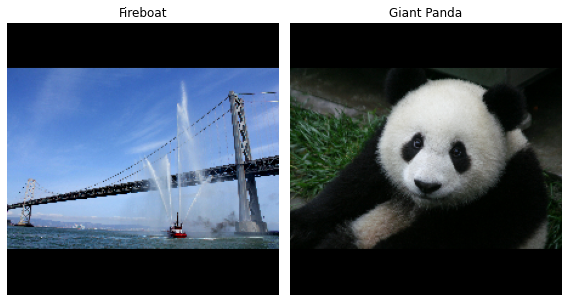

In [9]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 2, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

### 이미지 분류하기

이러한 이미지를 분류하고 가장 확신할 수 있는 상위 3가지 예측을 표시하는 것으로 시작하겠습니다. 다음은 상위 k개의 예측 레이블 및 확률을 검색하는 유틸리티 함수입니다.

In [10]:
def top_k_predictions(img, k=3):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

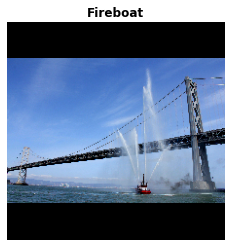

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%


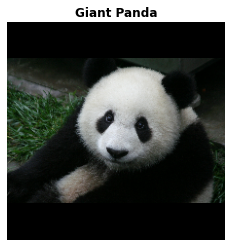

giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%


In [11]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

  pred_label, pred_prob = top_k_predictions(img_tensor)
  for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

## 통합 그래디언트 계산하기

모델 Inception V1은 입력 특성 공간, 이미지 픽셀 값 및 0과 1 사이의 ImageNet 클래스 확률 값으로 정의된 출력 공간 사이의 매핑을 설명하는 학습된 함수입니다. 신경망에 대한 초기 해석 가능성 메서드는 그래디언트를 사용하여 특성에 중요도 점수를 배정했으며, 이는 모델의 예측 함수를 따라 주어진 지점에서 모델 예측에 상대적으로 가장 가파른 로컬을 갖는 픽셀을 알려줍니다. 그러나 그래디언트는 픽셀 값과 관련하여 모델 예측 함수에서 *로컬* 변화만을 설명하고 전체 모델 예측 함수를 완전히 설명하지는 않습니다. 모델이 개별 픽셀의 범위와 올바른 ImageNet 클래스 사이의 관계를 완전히 "학습"함에 따라 이 픽셀의 그래디언트가 *포화*되어 점점 작아지고 결국 0이 되기도 합니다. 아래의 간단한 모델 함수를 살펴보겠습니다.

In [ ]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

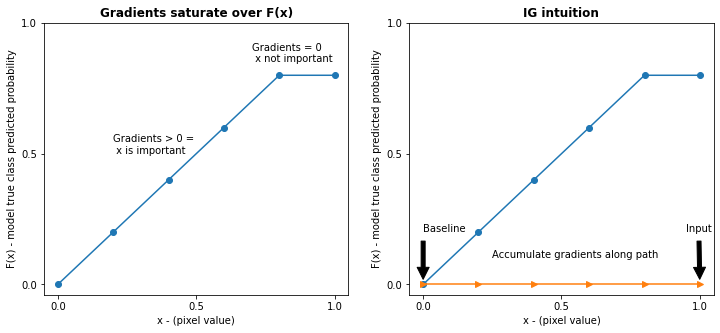

In [14]:
#@title
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();

- **왼쪽**: 픽셀 `x`에 대한 모델의 그래디언트는 0.0과 0.8 사이의 양수이지만 0.8과 1.0 사이에서 0.0이 됩니다. 픽셀 `x`는 실제 클래스에서 모델을 예상 확률 80%로 만드는 데 큰 영향을 미칩니다. <em data-md-type="emphasis">픽셀 `x`의 중요도가 작거나 불연속적이라면 합당할까요?</em>

- **오른쪽**: IG에 적용되는 논리는 픽셀 `x`의 로컬 그래디언트를 축적하고 이것이 모델의 전체 출력 클래스 확률을 얼마나 높이거나 줄이는지에 대한 점수로 중요도를 나타내는 것입니다. IG를 세 부분으로 나누어 계산할 수 있습니다.

    1. 특성 공간에서 0(기준선 또는 시작점)과 1(입력 픽셀 값) 사이의 직선을 따라 작은 단계를 보간합니다.
    2. 각 단계와 관련해 모델 예측 사이의 각 단계에서 그래디언트를 계산합니다.
    3. 이러한 로컬 그래디언트를 누적(누적 평균)하여 기준선과 입력 사이의 적분 근사값을 계산합니다.

이러한 논리를 강화하기 위해 아래의 "Fireboat" 이미지 예에 IG를 적용하여 이 세 부분을 살펴보겠습니다. 

### 기준선 수립하기

기준선은 특성 중요도를 계산하기 위한 시작점으로 사용되는 입력 이미지입니다. 직관적으로, 기준선의 설명적 역할을 입력 이미지에 있을 때 "Fireboat" 예측에 미치는 각 픽셀의 영향과 대비시켜 각 픽셀이 없을 때 "Fireboat" 예측에 미치는 영향을 나타내는 것으로 생각할 수 있습니다. 결과적으로, 기준선의 선택은 픽셀 특성의 중요성을 해석하고 시각화하는 데 중심적인 역할을 합니다. 기준선 선택에 대한 자세한 내용은 이 튜토리얼 하단의 "다음 단계" 섹션에 있는 리소스를 참조하세요. 여기서는 픽셀 값이 모두 0인 검정색 이미지를 사용합니다.

실험해 볼 수 있는 다른 선택으로 전체 흰색 이미지 또는 `tf.random.uniform(shape=(224,224,3), minval=0.0, maxval=1.0)`로 만들 수 있는 임의의 이미지가 있습니다.

In [ ]:
baseline = tf.zeros(shape=(224,224,3))

In [ ]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

### 수식을 코드로 압축 해제하기

통합 그래디언트의 수식은 다음과 같습니다.

$IntegratedGradients_{i}(x) ::= (x_{i} - x'*{i})\times\int*{\alpha=0}^1\frac{\partial F(x'+\alpha \times (x - x'))}{\partial x_i}{d\alpha}$

여기서:

$_{i}$ = 특성<br> $x$ = 입력<br> $x'$ = 기준선<br> $\alpha$ = 특성을 교란시키는 보간 상수

실제로, 정적분을 계산하는 것이 수치적으로 항상 가능한 것은 아니며 계산 비용이 많이 들 수 있으므로 다음과 같은 수치적 근사값을 계산합니다.

$IntegratedGrads^{approx}*{i}(x)::=(x*{i}-x'*{i})\times\sum*{k=1}^{m}\frac{\partial F(x' + \frac{k}{m}\times(x - x'))}{\partial x_{i}} \times \frac{1}{m}$

여기서:

$*{i}$ = 특성(개별 픽셀)<br> $x$ = 입력(이미지 텐서)<br> $x'$ = 기준선(이미지 텐서)<br> $k$ = 배율 조정된 특성 섭동 상수<br> $m$ = 적분의 리만 합 근사의 단계 수<br> $(x*{i}-x'_{i})$ = 기준선과의 차이에 대한 항. 이것은 적분된 그래디언트의 크기를 조정하고 원본 이미지의 관점에서 이를 유지하는 데 필요합니다. 기준선 이미지에서 입력까지의 경로는 픽셀 공간에 있습니다. IG를 사용하면 직선으로 통합(선형 변환)하므로 충분한 단계를 통해 $\alpha$와 관련해 보간된 이미지 함수의 도함수의 적분 항과 대략 동일해집니다. 적분은 각 픽셀의 그래디언트에 경로를 따른 픽셀의 변화를 곱한 값을 합산합니다. $x := (x' + \alpha(x-x'))$를 대체하여 한 이미지에서 다른 이미지로의 균일한 단계로 이 적분을 구현하는 것이 더 간단합니다. 따라서 변수를 변경하면 $dx = (x-x')d\alpha$가 주어집니다. $(x-x')$ 항은 상수이며 적분에서 제외됩니다.

### 이미지 보간하기

$IntegratedGrads^{approx}*{i}(x)::=(x*{i}-x'*{i})\times\sum*{k=1}^{m}\frac{\partial F(\overbrace{x' + \frac{k}{m}\times(x - x')}^\text{interpolate m images at k intervals})}{\partial x_{i}} \times \frac{1}{m}$

먼저 기준선과 원본 이미지 사이에 [선형 보간](https://en.wikipedia.org/wiki/Linear_interpolation)을 생성합니다. 보간된 이미지는 특성 공간에서 기준선과 입력 사이의 작은 단계로 생각할 수 있으며 원래 수식에서 $\alpha$로 표시됩니다.

In [ ]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [ ]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

위 함수를 사용하여 검정색 기준선 이미지와 예제 "Fireboat" 이미지 사이의 알파 간격으로 선형 경로를 따라 보간된 이미지를 생성해 보겠습니다.

In [ ]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)

보간된 이미지를 시각화해 보겠습니다. 참고: 보간된 각 이미지의 강도를 지속적으로 증가시키는 것으로 $\alpha$ 상수를 생각할 수도 있습니다.

In [ ]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

### 그래디언트 계산하기

이제 특성 변경과 모델 예측 변경 사이의 관계를 측정하기 위해 그래디언트를 계산하는 방법을 살펴보겠습니다. 이미지의 경우, 그래디언트는 모델의 예측 클래스 확률에 미치는 영향이 가장 큰 픽셀이 무엇인지를 알려줍니다.

$IntegratedGrads^{approx}*{i}(x)::=(x*{i}-x'*{i})\times\sum*{k=1}^{m}\frac{\overbrace{\partial F(\text{interpolated images})}^\text{compute gradients}}{\partial x_{i}} \times \frac{1}{m}$

여기서: <br>$F()$ = 모델의 예측 함수 <br>$\frac{\partial{F}} {\partial{x_i}}$ = 각 특성 $x_i$에 상대적인 모델 F의 예측 함수에 대한 그래디언트(부분 도함수 $\partial$의 벡터)

용이한 그래디언트 계산을 위해 TensorFlow에서 [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape)가 이용됩니다.

In [ ]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

올바른 출력과 관련하여 보간 경로를 따라 각 이미지의 그래디언트를 계산해 보겠습니다. 모델은 각 클래스의 예측 확률로 변환하는 로짓과 함께 `(1, 1001)` 형상의 `Tensor`를 반환한다는 점을 상기하세요. 올바른 ImageNet 대상 클래스 인덱스를 이미지의 `compute_gradients` 함수로 전달해야 합니다.

In [ ]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=555)

`(n_interpolated_images, img_height, img_width, RGB)`의 출력 형상에 주목하세요. 이는 보간 경로를 따라 각 이미지의 모든 픽셀에 대한 그래디언트를 제공합니다. 이러한 그래디언트는 특성 공간의 각 작은 단계에 대해 모델 예측의 변화를 측정하는 것으로 생각할 수 있습니다.

In [ ]:
print(path_gradients.shape)

**그래디언트 포화 시각화하기**

위에서 계산한 그래디언트는 모델의 예측된 "Fireboat" 확률에 대한 *로컬* 변경화를 설명하며 *포화*될 수 있습니다.

이러한 개념은 아래 2개의 플롯에서 위에서 계산한 그래디언트를 사용하여 시각화됩니다.

In [ ]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

In [ ]:
#@title
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

- **왼쪽**: 이 플롯은 "Fireboat" 클래스에 대한 모델의 신뢰도가 전체 알파에 걸쳐 어떻게 달라지는지 보여줍니다. 약 40%의 최종 "Fireboat" 예상 확률에서 안정화되기 전에 그래디언트 또는 라인의 기울기가 0.6과 1.0 사이에서 크게 평평해지거나 포화되는 것에 주목하세요.

- **오른쪽**: 오른쪽 플롯은 전체 알파에 걸쳐 평균 그래디언트 크기를 더 직접적으로 보여줍니다. 값이 0으로 급격하게 접근하고 심지어 잠깐 동안 0 미만으로 떨어지는 모습에 주목하세요. 사실, 모델은 낮은 알파 값의 그래디언트에서 가장 많이 "학습"합니다. 이것을 직관적으로 보면, 모델이 정확한 예측을 위해 픽셀, 예를 들어 물대포를 학습하고 이러한 픽셀 그래디언트를 0으로 보내지만 여전히 상당히 불확실하고 알파 값이 원래 입력 이미지에 접근함에 따라 다리 또는 물 제트 픽셀에 중점을 두는 것으로 생각할 수 있습니다.

이 중요한 물대포 픽셀이 "Fireboat" 예측에 중요하게 반영되도록 하기 위해 아래에서 계속해서 각 픽셀이 "Fireboat" 예측 확률에 미치는 영향을 정확하게 근사시키기 위해 이러한 그래디언트를 누적하는 방법을 배워보겠습니다.


### 그래디언트 누적하기(적분 근사값 계산)

IG에 대한 적분의 수치적 근사값을 계산하는 방법에는 여러 가지가 있으며, 다양한 기능에 걸쳐 정확도와 수렴에서 득실 관계가 존재합니다. 널리 사용되는 메서드 클래스는 [리만 합(Riemann sums)](https://en.wikipedia.org/wiki/Riemann_sum)입니다. 여기서는 사다리꼴 규칙을 사용합니다(이 튜토리얼 마지막에 다른 근사 계산을 살펴보기 위한 추가 코드가 나와 있음).

$IntegratedGrads^{approx}*{i}(x)::=(x*{i}-x'*{i})\times \overbrace{\sum*{k=1}^{m}}^\text{Sum m local gradients} \text{gradients(interpolated images)} \times \overbrace{\frac{1}{m}}^\text{Divide by m steps}$

수식에서 `m` 그래디언트 전체에 걸쳐 합산하고 `m` 단계를 나눈 것을 볼 수 있습니다. <em data-md-type="emphasis">`m` 보간된 예측 및 입력 이미지의 로컬 그래디언트 평균</em>으로 파트 3에 대해 두 가지 연산을 함께 구현할 수 있습니다.

In [ ]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

`integral_approximation` 함수는 기준선과 원본 이미지 사이의 보간된 이미지와 관련하여 대상 클래스의 예측 확률에 대한 그래디언트를 가져옵니다.

In [ ]:
ig = integral_approximation(
    gradients=path_gradients)

보간된 `m` 이미지의 그래디언트 전체에서 평균을 구하면 원래 "Giant Panda" 이미지와 같은 형상의 통합 그래디언트 텐서가 반환되는 것을 확인할 수 있습니다.

In [ ]:
print(ig.shape)

### 모두 함께 실행하기

이제 앞서 알아본 3개의 일반 파트를 `IntegratedGradients` 함수로 결합하고 [@ tf.function](https://www.tensorflow.org/guide/function) 데코레이터를 사용하여 고성능 호출 가능 Tensorflow 그래프로 컴파일합니다. 이를 위해 아래 5 단계를 거칩니다.


$IntegratedGrads^{approx}*{i}(x)::=\overbrace{(x*{i}-x'*{i})}^\text{5.}\times \overbrace{\sum*{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$

1. 알파 $\alpha$ 생성

2. 보간된 이미지 = $(x' + \frac{k}{m}\times(x - x'))$ 생성

3. 입력 특성 = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$와 관련하여 모델 $F$ 출력 예측 사이의 그래디언트 계산

4. 평균 그래디언트를 통한 적분 근사 = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. 원본 이미지 = = $(x_{i}-x'_{i}) \times \text{integrated gradients}$와 관련해 적분된 그래디언트의 크기를 조정합니다. 이 단계가 필요한 이유는 여러 보간된 이미지에 걸쳐 누적된 속성 값의 단위가 같도록 하고 원본 이미지의 픽셀 중요도를 충실하게 나타내기 위해서입니다.

In [ ]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []
    
  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)
      
  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [ ]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [ ]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors['Fireboat'],
                                       target_class_idx=555,
                                       m_steps=240)

다시 한 번, IG 특성 속성이 입력 "Fireboat" 이미지와 같은 형상을 갖는다는 것을 확인할 수 있습니다.

In [ ]:
print(ig_attributions.shape)

이 문서에서는 예제에 따라 20에서 300 사이의 단계 수를 제안합니다(실제로 적분을 정확하게 근사시키기 위해 수천 단계까지도 이용함). 이 튜토리얼 마지막의 "다음 단계" 리소스에서 적절한 단계 수를 확인하기 위한 추가 코드를 찾을 수 있습니다.

### 속성 시각화하기

이제 속성을 시각화하고 원본 이미지에 오버레이할 준비가 되었습니다. 아래 코드는 색상 채널에서 적분된 그래디언트의 절대값을 합산하여 속성 마스크를 생성합니다. 이 플롯 메서드는 모델 예측에 미치는 픽셀의 상대적 영향을 포착합니다. 

In [ ]:
#@title
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

"Fireboat" 이미지의 속성을 살펴보면 모델이 물 대포와 주둥이가 정확한 예측에 기여하는 것으로 식별하는 것을 확인할 수 있습니다.

In [ ]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

"거대한 팬더" 이미지에서 속성은 팬더 얼굴의 질감, 코 및 털을 강조합니다.

In [ ]:
_ = plot_img_attributions(image=img_name_tensors['Giant Panda'],
                          baseline=baseline,
                          target_class_idx=389,
                          m_steps=55,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.5)

## 용도 및 제한

사용 사례

- 모델을 배포하기 전에 통합 그래디언트와 같은 기법을 사용하면 작동 방식 및 그 이유에 대한 직관을 쉽게 개발할 수 있습니다. 이 기법으로 강조된 특성이 직관과 일치합니까? 그렇지 않은 경우 이는 모델 또는 데이터세트에 버그가 있음을 나타내거나 과적합임을 나타낼 수 있습니다.

한계

- 통합 그래디언트는 개별 예제에서 특성의 중요도를 제공하지만 전체 데이터 세트에 걸쳐 전체 특성의 중요도를 제공하지는 않습니다.

- 적분 그래디언트는 개별 특성의 중요도를 제공하지만 특성 상호 작용 및 조합에 대해서는 설명하지 않습니다.

## 다음 단계

이 튜토리얼에서는 적분 그래디언트의 기본 구현을 제시했습니다. 다음 단계에서는 이 노트북을 사용하여 다양한 모델과 이미지로 이 기법을 시험해 볼 수 있습니다.

관심이 있는 독자를 위해 이 튜토리얼의 상세 버전(여러 기준선에 대한 코드와 함께 적분 근사치 계산 및 충분한 수의 단계를 결정하기 위한 코드 포함)을 [여기](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/blogs/integrated_gradients)서 다운로드할 수 있습니다.

이해도를 높이려면 이전 TensorFlow 버전에서의 구현을 포함한 [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365) 및 [Github 리포지토리](https://github.com/ankurtaly/Integrated-Gradients)를 확인하세요. [distill.pub](https://distill.pub/2020/attribution-baselines/)에서 특성 속성 및 여러 기준선의 영향에 대해서도 알아볼 수 있습니다.

특성 중요도, 모델 오류 분석 및 데이터 쏠림 모니터링을 위한 실무 머신러닝 워크플로에 IG를 통합하고 싶습니까? IG 속성을 지원하는 Google Cloud의 [Explainable AI](https://cloud.google.com/explainable-ai) 제품을 확인해 보세요. Google AI PAIR 리서치 그룹은 IG 특성 속성 시각화를 포함하여 모델 디버깅에 사용할 수 있는 [What-if 도구](https://pair-code.github.io/what-if-tool/index.html#about)를 오픈소스로 제공합니다.